# Midterm Project

The midterm project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Please note that the project is *individual*, and the solutions will be checked for substantial overlap. However, you should feel free to discuss problems and ideas with your class mates, just do not share code.

Your submission should include all outputs and be self-contained, so it can be executed if necessary.


## Submission
The project is due on March 29, 23:59 CET. Late submissions will not be considered, and graded as 0. To submit, please:

1. rename this file with your student ID
2. copy this file and all additional data into a folder with your student ID
3. zip the folder
4. upload to Blackboard and send a copy or link to a copy of the zip file to Tommaso Fornaciari <fornaciari@unibocconi.it>

# Data and Preprocessing (5 pts)

Pick a data set, either from the ones we have used in class, or one that you have found yourself (up to 2 bonus points, depending on size and complexity).
Briefly (max. 100 words!) describe the content and type of the data set (book, reviews, Twitter, ...). 

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

###### Dataset description:

I chose to analyze emails of the Enron corporation which were made public during the fraud investigation. It contains data from about 150 users, mostly senior management of Enron. Invalid email addresses were converted to something of the form user@enron.com whenever possible (i.e., recipient is specified in some parse-able format like "Doe, John" or "Mary K. Smith") and to no_address@enron.com when no recipient was specified. Dataset is published at https://www.cs.cmu.edu/~./enron/.

Some emails were removed for privacy reasons upon the request of the email’s author or recipient.
Here's a history of removals:

2009: removed whole directory of  Jeffery Skilling (CEO)

2011: removed some 3 sent emails and 3 document folders of Gay R. (unknown position to me)

2015: removed 11 sent emails and 12 incoming emails  of Cooper Richey (manager)

Dataset currently contains 517,401 rows, with observations for various variables such as (Message-ID, Date, From, To, Subject, Content, etc.)

Size of the raw dataset in CSV format is 1.4 GB. I list the instructions for downloading of the dataset, and I will also make the dataset available via Google Drive.

In [1]:
# Loading of the needed packages

# System
import os

# Data analysis and processing
import pandas as pd
import numpy as np
import random
import email
import spacy
from nltk import SnowballStemmer # for Stemming
from sklearn.feature_extraction.text import CountVectorizer # For matrix representations and tfidf table
from sklearn.feature_extraction.text import TfidfVectorizer # For matrix factorization 
from collections import Counter # For counting tokens
from collections import defaultdict # For stemming and topic models
from nltk.tokenize.regexp import RegexpTokenizer
import re # Regex
import nltk # Natural language toolkit
import itertools
import string # For regex
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import time # To know how long training took
import multiprocessing # To speed things up by parallelizing
from sklearn.decomposition import TruncatedSVD # For SVD
from sklearn.decomposition import NMF # For NMF
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION


# Network analysis
import networkx as nx # Network analysis


# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import squarify

%matplotlib inline

os.system("taskset -p 0xff %d" % os.getpid())
print(os.getcwd())

/home/lini/Desktop/II semester/NATURAL LANGUAGE PROCESSING/midterm/3002493


## Downloading the big dataset and extracting text of the emails

Here I present two ways to download the data:

###### 1. From my Google Drive link: 

https://drive.google.com/drive/folders/1lY-8j77_wfGp3z4yDwC4OEiQ2lhSc_Lv?usp=sharing

###### 2. Since the database is on kaggle, we can use kaggle API to get the data:

pip install kaggle

pip install --user kaggle (for mac and linux users)

download kaggle.json file from your profile and store it as instructed here (https://github.com/Kaggle/kaggle-api)

to download zip file, run in terminal: kaggle datasets download -d wcukierski/enron-email-dataset

unzip the file, size of CSV file is 1.4 gb

In [3]:
df = pd.read_csv('emails.csv')

Getting to know the data.

In [4]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [5]:
df.shape

(517401, 2)

There are 517,401 emails. Those contain metadata, some of which we do not want to use. Let's organize the data better for our use.

In [6]:
df.message

0         Message-ID: <18782981.1075855378110.JavaMail.e...
1         Message-ID: <15464986.1075855378456.JavaMail.e...
2         Message-ID: <24216240.1075855687451.JavaMail.e...
3         Message-ID: <13505866.1075863688222.JavaMail.e...
4         Message-ID: <30922949.1075863688243.JavaMail.e...
5         Message-ID: <30965995.1075863688265.JavaMail.e...
6         Message-ID: <16254169.1075863688286.JavaMail.e...
7         Message-ID: <17189699.1075863688308.JavaMail.e...
8         Message-ID: <20641191.1075855687472.JavaMail.e...
9         Message-ID: <30795301.1075855687494.JavaMail.e...
10        Message-ID: <33076797.1075855687515.JavaMail.e...
11        Message-ID: <25459584.1075855687536.JavaMail.e...
12        Message-ID: <13116875.1075855687561.JavaMail.e...
13        Message-ID: <2707340.1075855687584.JavaMail.ev...
14        Message-ID: <2465689.1075855687605.JavaMail.ev...
15        Message-ID: <1115198.1075855687626.JavaMail.ev...
16        Message-ID: <19773657.10758556

Example of an email content and the metadata that accompanies it.

In [7]:
print(df['message'][3])

Message-ID: <13505866.1075863688222.JavaMail.evans@thyme>
Date: Mon, 23 Oct 2000 06:13:00 -0700 (PDT)
From: phillip.allen@enron.com
To: randall.gay@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Randall L Gay
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Randy,

 Can you send me a schedule of the salary and level of everyone in the 
scheduling group.  Plus your thoughts on any changes that need to be made.  
(Patti S for example)

Phillip


In [8]:
# Helper functions for extracting the content and organizing it into a dataframe
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain': # Extracting text data
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [9]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
# Parse content from emails
df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del messages

In [10]:
df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [11]:
print('shape of the dataframe:', df.shape)
# Find number of unique values in each columns
for col in df.columns:
    print(col, df[col].nunique())

shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [12]:
# Set index and drop columns with two few values
df = df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [13]:
# Parse datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, utc=True) # It shows UTC time.

In [14]:
df.dtypes

Date          datetime64[ns, UTC]
From                       object
To                         object
Subject                    object
X-From                     object
X-To                       object
X-cc                       object
X-bcc                      object
X-Folder                   object
X-Origin                   object
X-FileName                 object
content                    object
user                       object
dtype: object

In [15]:
print(df.shape)
for col in df.columns:
    print(col, df[col].nunique())

(517401, 13)
Date 224122
From 20328
To 54748
Subject 159290
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [16]:
df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


Let's check how the random email looks like in our new dataframe.

In [17]:
print(df['content'][10])

Mr. Buckner,

 For delivered gas behind San Diego, Enron Energy Services is the appropriate 
Enron entity.  I have forwarded your request to Zarin Imam at EES.  Her phone 
number is 713-853-7107.  

Phillip Allen


Let's take out only the column that contains the emails and save it to new CSV file, so we can restart the kernel, free up our memory and start working on preprocessing of the emails.

In [20]:
df1 = df['content']
df1

In [ ]:
df1.to_csv('emails_text.csv',index=False, header=True)

## Preprocessing of the extracted email text

Restart the kernel here to free the memory up, and load newly created CSV file that contains only text. Load the packages again.

In [ ]:
os._exit(00)

In [1]:
# Loading of the needed packages

# System
import os

# Data analysis and processing
import pandas as pd
import numpy as np
import random
import email
import spacy
from nltk import SnowballStemmer # for Stemming
from sklearn.feature_extraction.text import CountVectorizer # For matrix representations and tfidf table
from sklearn.feature_extraction.text import TfidfVectorizer # For matrix factorization 
from collections import Counter # For counting tokens
from collections import defaultdict # For stemming and topic models
from nltk.tokenize.regexp import RegexpTokenizer
import re # Regex
import nltk # Natural language toolkit
import itertools
import string # For regex
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import time # To know how long training took
import multiprocessing # To speed things up by parallelizing
from sklearn.decomposition import TruncatedSVD # For SVD
from sklearn.decomposition import NMF # For NMF
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION


# Network analysis
import networkx as nx # Network analysis


# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import squarify

%matplotlib inline

os.system("taskset -p 0xff %d" % os.getpid())
print(os.getcwd())

/home/lini/Desktop/II semester/NATURAL LANGUAGE PROCESSING/midterm/3002493


I wanted to analyze the complete dataset and I tried to run the code on it, but even after waiting for 10 hours, my computer unfortunately did not mange to finish. So, I have decided to do the final analysis using the sample from the database (sample size = 10,001 emails - each containing one or more sentences), which is approximatelly 1.9% of the total email count.

In [2]:
# df = pd.read_csv('emails_text.csv') # When doing the analysis for the whole dataset N = 517401
# N = df.shape[0]

# ------------------------------------------------------------------------------------------------

# Random sampling
# Code wass initially writen and tested on smaller chunk of data, in order to speed up the process
N = 10001
df = pd.read_csv('emails_text.csv').sample(n=N, replace=False) 


n = N - 1
increment = n/10
N1 = int(increment)
N2 = int(increment*2)
N3 = int(increment*3)
N4 = int(increment*4)
N5 = int(increment*5)
N6 = int(increment*6)
N7 = int(increment*7)
N8 = int(increment*8)
N9 = int(increment*9)
N10 = int(increment*10)

df1 = df[:N1]
df2 = df[N1:N2]
df3 = df[N2:N3]
df4 = df[N3:N4]
df5 = df[N4:N5]
df6 = df[N5:N6]
df7 = df[N6:N7]
df8 = df[N7:N8]
df9 = df[N8:N9]
df10 = df[N9:N10]
df11 = df[N10:N]

l = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11]

Since nlp package had maximum length of 1000000 characters for preprocessing. I have decided to split the dataframe into 11 smaller dataframes, and to run preprocessing steps via looping. Also I have increased nlp.max_length to be on the safe side. At the end of preprocessing steps, I concatenate the sub dataframes back into the original length. 

In [3]:
df.shape

(10001, 1)

In [4]:
df.head()

,content
209353,Sorry to hear this - I have generally shared m...
9114,CTS/BFM market......Oregon Convention Center.....
261808,Is that what ECR want to do with it?\n\n -----...
451720,----- Forwarded by Elizabeth Sager/HOU/ECT on ...
400139,\n\n -----Original Message-----\nFrom: \tThome...


In [5]:
nlp = spacy.load('en') # Loading the spacy package for english language
nlp.max_length = 93621305 # Increasing the max_length for nlp package

# Creating a preprocessing function
def pre_processing(certain_df):
    # remove numbers
    certain_df['content'] = certain_df['content'].str.replace('\d+', '')

    # Creating a function to remove the mentions and URLs
    def remove_mentions_urls(text):
        text_out = re.sub(r'@[A-Za-z0-9]+','',text)
        re.sub('https?://[A-Za-z0-9./]+','',text_out)
        return text_out

    # Call the funtion to clean the mentions and URLs
    certain_df['content'] = certain_df['content'].apply(lambda x: remove_mentions_urls(x))

    # Creating a function to remove the non-alphanumeric characters
    def remove_nonalphanumeric(text):
        text_out = "".join([char for char in text if char not in string.punctuation])
        return text_out

    # Call the funtion to clean the punctuation
    certain_df['content_lemm'] = certain_df['content'].apply(lambda x: remove_nonalphanumeric(x))

    # We want to get the dictionary form of each word, to reduce variation
    # Creating a function for lemmatizing
    def lemmatize(text):
        out_text = [token.lemma_ if token.lemma_ != '-PRON-' else token.lower_ for token in nlp(text)]
        return out_text

    # Call the function to lemmatize
    certain_df['content_lemm'] = certain_df['content_lemm'].apply(lambda x: lemmatize(x))

    dataset_size = list(itertools.chain.from_iterable(certain_df['content_lemm']))

    print("Unique words: "+str(len(set(dataset_size))))

    # Creating a function for stopwords removal
    stopwords = nltk.corpus.stopwords.words('english')

    def remove_stopwords(lemmatized_list):
        text_out = [word for word in lemmatized_list if word not in stopwords]
        return text_out

    # Call the function to remove the stopwords
    certain_df['content_lemm'] = certain_df['content_lemm'].apply(lambda x: remove_stopwords(x))

    dataset_size = list(itertools.chain.from_iterable(certain_df['content_lemm']))

    print("Unique words: "+str(len(set(dataset_size))))
    
    # Creating the function to concatinate the lemmatized list in order to create lemmatized sentence
    def concatinate_to_str(lemmatized_list):
        text_out = ' '.join(lemmatized_list)
        return text_out

    # Call the function to create the lemmatized sentence
    certain_df['lemmatized_sentence'] = certain_df['content_lemm'].apply(lambda x: concatinate_to_str(x))

    # Replace new_line symbol with a blank space
    certain_df['lemmatized_sentence'] = certain_df['lemmatized_sentence'].replace('\n',' ', regex=True)

    # Replace some symbol that stayed in the text after preprocessing
    certain_df['lemmatized_sentence'] = certain_df['lemmatized_sentence'].replace('\t',' ', regex=True)

    # Replace HOUECT part of words (left after preprocessing) to make it readable and comparable
    certain_df['lemmatized_sentence'] = certain_df['lemmatized_sentence'].replace('.OUECT','', regex=True)

    # Replace HOUECT part of words (left after preprocessing) to make it readable and comparable
    certain_df['lemmatized_sentence'] = certain_df['lemmatized_sentence'].replace('.ouect','', regex=True)
    return certain_df

In [6]:
for i in range(len(l)):
    pre_processing(l[i])

/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

Unique words: 22164


/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Unique words: 22039


/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

Unique words: 25020
Unique words: 24896
Unique words: 24488
Unique words: 24364
Unique words: 22814
Unique words: 22692
Unique words: 26655
Unique words: 26529
Unique words: 24210
Unique words: 24087
Unique words: 26237
Unique words: 26114
Unique words: 25806
Unique words: 25683
Unique words: 25105
Unique words: 24981
Unique words: 21723
Unique words: 21601
Unique words: 16
Unique words: 11


In [7]:
df = pd.concat(l, axis=0)
df.shape

(10001, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10001 entries, 209353 to 155906
Data columns (total 3 columns):
content                10001 non-null object
content_lemm           10001 non-null object
lemmatized_sentence    10001 non-null object
dtypes: object(3)
memory usage: 312.5+ KB


In [9]:
df.head()

,content,content_lemm,lemmatized_sentence
209353,Sorry to hear this - I have generally shared m...,"[sorry, hear, , generally, share, material, c...",sorry hear generally share material colleagu...
9114,CTS/BFM market......Oregon Convention Center.....,"[CTSBFM, marketoregon, Convention, CenterNE, M...",CTSBFM marketoregon Convention CenterNE MLK Blvd
261808,Is that what ECR want to do with it?\n\n -----...,"[ECR, want, \n\n , original, message, \n, From...",ECR want original message From Mrha Je...
451720,----- Forwarded by Elizabeth Sager/HOU/ECT on ...,"[ , forward, Elizabeth, SagerHOUECT, , AM, \...",forward Elizabeth Sager AM Andy Katz ...
400139,\n\n -----Original Message-----\nFrom: \tThome...,"[\n\n , original, message, \n, From, \t, Thome...",original message From Thome Stephen ...


In [10]:
# Let's move our content to lists
documents_orig = df['content'].to_list()
documents = df['lemmatized_sentence'].to_list()
documents_tok_lemm = df['content_lemm'].to_list()

In [12]:
# Here I delete sub dataframes and used variables, as they are not needed anymore and to free up the memory

del df1
del df2
del df3
del df4
del df5
del df6
del df7
del df8
del df9
del df10
del df11
del l
del N1
del N2
del N3
del N4
del N5
del N6
del N7
del N8
del N9
del N10
del n
del increment
del i

# Analysis (16 pts)

Describe what you are investigating with the data (max. 100 words, 3 pts), and apply at least one version of *each* of the following analysis methods to the data set (justify your choices):
1. TFIDF analysis of important terms **or** latent topics from matrix factorization (2 pts)
2. Topic modeling with LDA (4 pts)
3. Dense word or document embeddings (4 pts)
4. Clustering (3 pts)

If appropriate for your probelm, feel free to explore other methods we discussed (NER, parsing, POS, etc.), or algorithms not covered in class (e.g., clustering algorithms, etc.), as long as they do not require additional libraries (up to 2 bonus points).

###### Goal Description:

1. I first check for the most frequent words using n-grams (1-3).

2. I use Word2vec to compare the words and get similar words for the ones I thought it would be interesting to check. The goal is to understand the culture of the company and how were they communicating among them.

3. Then I use TF-IDF to find out the most important unigrams and bigrams. I also check what are the most important words according to TF-IDF when we take into consideration all n-grams that belog to range (1-3).

4. I used LDA Topic model to find different repeating and important topics for people working in Enron corporation. However, I believe the results would be more compelling if I could have used the complete dataset.

5. Latent topics and dimensions of matrix factorization (SVD and NMF) were used to check against LDA and compare topics.


## Representations

### Discrete Sparse Representations

#### N-grams

In [13]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.001, max_df=0.75, stop_words='english')
X = vectorizer.fit_transform(documents)

print(X.shape)

(10001, 17027)


In [14]:
most_freq_words = X.sum(axis=0).argsort()[0,-15:].tolist()[0]
[vectorizer.get_feature_names()[w] for w in most_freq_words]

['time',
 'thank',
 'price',
 'message',
 'send',
 'new',
 'company',
 'cc',
 'energy',
 'email',
 'power',
 'say',
 'pm',
 'subject',
 'enron']

The most frequent n-grams in range (1-3) seem to be unigrams and all terms seems to be very important for such a company. Time was important in their trading business, and obviously the price was very important. Energy is important as their business activities were centered around energy.

In [15]:
del X
del vectorizer
del most_freq_words

### Dense Distributed Representations - Word embeddings with Word2vec

In [16]:
corpus = [document.split() for document in documents]
# initialize model
w2v_model = Word2Vec(size=100, 
                     window=15, 
                     hs=0, # hierarchical sampling
                     sample=0.000001, # downsample
                     negative=5, # 
                     min_count=100, # words that have appeared at least 100 times
                     workers=-1, # use all available cores of the machine
                     iter=100
)

w2v_model.build_vocab(corpus)

w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)


(0, 0)

In [17]:
# Finding the most similar words.
word1 = "money"
word2 = "price"

# # compare
print(w2v_model.wv.similarity(word1, word2))

# get the 3 most similar words
print(w2v_model.wv.most_similar(word1, topn=3))

-0.028313844
[('Settlement', 0.30465230345726013), ('Forwarded', 0.3045516312122345), ('back', 0.30095189809799194)]


/home/lini/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [18]:
# Finding the most similar words.
word1 = "contract"
word2 = "price"

# # compare
print(w2v_model.wv.similarity(word1, word2))

# get the 3 most similar words
print(w2v_model.wv.most_similar(word1, topn=3))

-0.10234597
[('Maggi', 0.4452579617500305), ('interconnection', 0.36449113488197327), ('Page', 0.34498822689056396)]


We can see that in their communication money and price were much less similar than for example contract and price, which makes sence since their profir was based on prices that are set in contracts. We also can see that money is very similar and related to settlement which is indicative of their trading business model. Also, contract is similar to Maggi and Page, which makes me think that they would be in charge of drafting contracts (or contracts somehow have to go through them).

In [20]:
del corpus
del w2v_model
del word1
del word2

## TF-IDF

In [26]:
# Only unigrams

In [21]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(documents)

In [22]:
vectorizer = CountVectorizer(analyzer='word', min_df=0.001, max_df=0.75, stop_words='english')

X2 = vectorizer.fit_transform(documents)

In [23]:
X.shape, X2.shape

((10001, 7977), (10001, 7977))

In [24]:
word_counts = X2.toarray()
word_tfidf = X.toarray()
word_tfidf[word_tfidf < 0.2] = 0

df_1 = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': word_counts.sum(axis=0), 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': word_tfidf.sum(axis=0)
                       })

In [25]:
df_1 = df_1.sort_values(['tfidf', 'tf', 'idf'])
df_1.tail(15)

,word,tf,idf,tfidf
2192,eb,560,4.090243,25.918360
5392,pl,222,5.110674,26.815865
641,ben,361,4.798894,28.147370
4518,meeting,2168,3.254948,28.717031
7200,thank,4402,2.107651,28.867145
3772,jeff,1601,3.459439,28.972342
6017,request,2028,3.274198,30.581022
6000,report,2920,3.358298,31.177663
6322,sara,867,4.408422,34.839934
2672,final,1139,3.875486,35.879063


Here we can see that individual names are important unigrams. This is interesting to me, because it indicates the importance of people to their business model and that people are actually the pillars of the businesses (No business can prosper without the good people).

In [26]:
del X
del X2
del tfidf_vectorizer
del vectorizer
del word_counts
del word_tfidf

In [ ]:
# Only bigrams

In [27]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(documents)

In [28]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df=0.001, max_df=0.75, stop_words='english')

X2 = vectorizer.fit_transform(documents)

In [29]:
X.shape, X2.shape

((10001, 6841), (10001, 6841))

In [30]:
word_counts = X2.toarray()
word_tfidf = X.toarray()
word_tfidf[word_tfidf < 0.2] = 0

df_2 = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': word_counts.sum(axis=0), 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': word_tfidf.sum(axis=0)
                       })

In [31]:
df_2 = df_2.sort_values(['tfidf', 'tf', 'idf'])
df_2.tail(15)

,word,tf,idf,tfidf
4879,question thank,140,5.276066,29.138053
3512,make sure,341,4.503430,29.384045
3098,kay manncorpenron,309,4.902273,29.758510
6090,thank help,223,4.839902,31.066122
3410,look forward,409,4.297037,31.672041
2748,image image,983,5.816091,31.847080
5489,send thursday,487,4.387494,32.256810
5491,send tuesday,521,4.393429,32.296383
4207,original message,2809,2.855538,35.992579
259,attach file,301,4.863433,39.260657


Bigrams tells us that people in Enron considered letting people know some information very important. Also, file attachment is important. I would think because in business context people have to support their words by some analysis/research/contract.

In [32]:
del X
del X2
del tfidf_vectorizer
del vectorizer
del word_counts
del word_tfidf

In [ ]:
# n-gram range = (1,3)

In [33]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.001, max_df=0.75, stop_words='english', sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(documents)

In [34]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.001, max_df=0.75, stop_words='english')

X2 = vectorizer.fit_transform(documents)

In [35]:
X.shape, X2.shape

((10001, 17027), (10001, 17027))

In [36]:
word_counts = X2.toarray()
word_tfidf = X.toarray()
word_tfidf[word_tfidf < 0.2] = 0

df_1_3 = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': word_counts.sum(axis=0), 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': word_tfidf.sum(axis=0)
                       })

In [37]:
df_1_3 = df_1_3.sort_values(['tfidf', 'tf', 'idf'])
df_1_3.tail(15)

,word,tf,idf,tfidf
11685,presentation,534,4.601069,13.521973
775,attach file,301,4.863433,14.119107
15661,tonight,190,5.213328,14.242162
5441,file,1954,3.185002,14.292223
7019,image,2213,4.927337,14.692137
7671,jeff,1601,3.459439,14.784208
9357,meeting,2168,3.254948,15.278561
7945,kate,468,4.858682,15.728561
15281,thank,4402,2.107651,17.177199
1107,ben,361,4.798894,19.108135


However, when we look into the area of n-grams in range (1-3), we can notice than unigrams seem to be the most important as the top 15 n-grams by TF-IDF score are actually unigrams. Those refer to attachments, deals and people.

In [38]:
del X
del X2
del tfidf_vectorizer
del vectorizer
del word_counts
del word_tfidf

## Topic model - LDA

In [51]:
# get dictionary
instances = df.lemmatized_sentence.apply(str.split)[:N]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.2)
print(dictionary, flush=True)

creating dictionary
Dictionary(1609 unique tokens: ['Houston', 'London', 'March', 'Original', 'PM']...)


In [52]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

num_topics = 10

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(model_corpus, # what to train on
                     num_topics=num_topics, # number of topics 
                     id2word=dictionary, # mappinf from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size # update after this many instances
                    )
    
print("done in {}".format(time.time()-start), flush=True)


translating corpus to IDs
tf-idf transformation
500.05
fitting model
done in 41.44775128364563


In [53]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "deal", "price", "power", "Kate", "California"
2 "Vince", "Kaminski", "J", "resume", "Shirley"
3 "attach", "file", "Report", "see", "x"
4 "Date", "HourAhead", "Final", "detect", "schedule"
5 "Mark", "PM", "Communications", "Tana", "meeting"
6 "business", "information", "access", "employee", "new"
7 "Sara", "Shackleton", "fax", "Smith", "EB"
8 "go", "good", "think", "want", "week"
9 "deal", "original", "Chris", "Mike", "Michelle"
10 "Kay", "intend", "recipient", "Agreement", "copy"


I will try to infer the topics, given the results of the LDA.

###### Topics:

1. Operations related to energy

2. Resumes and HR activity

3. Sending of attachments

4. Time management

5. Organizing meetings

6. Acquiring of new business information

7. Faxing and people

8. Creating new ideas during some (possibly free) time

9. Making deals

10. Concluding contracts

## Latent Topics and Dimensions: Matrix Factorization

In [54]:
# Helper function
def show_topics(a, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in a])
    return [', '.join(t) for t in topic_words]

In [55]:
documents = df.lemmatized_sentence.apply(str).tolist()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words='english', analyzer='word', min_df=0.001, max_df=0.5, sublinear_tf=True, use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(10001, 17027)


### SVD

In [56]:
k = 10

svd = TruncatedSVD(n_components=k)
%time U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

CPU times: user 1.7 s, sys: 12 ms, total: 1.71 s
Wall time: 1.15 s


In [57]:
print(U.shape, S.shape, V.shape)

(10001, 10) (10,) (10, 17027)


In [58]:
# Latent topics for SVD
terms = tfidf_vectorizer.get_feature_names()

sorted(show_topics(V, terms))

['attach, agreement, kay, file, draft',
 'description, calendar entry, central standard time, central standard, standard time',
 'detect, hourahead, final, variance, schedulingiso final',
 'email, vince, let, let know, know',
 'enron north america, enron north, north america, north america corp, america corp',
 'market, company, use, intend, recipient',
 'recipient, intend, intend recipient, message, original message',
 'subject, pm, enron, thank, cc',
 'vince, kaminski, vince kaminski, cc subject, deal',
 'vince, kaminski, vince kaminski, pm, vince kaminski pm']

I will compare these topics with the results of LDA.

###### Topics:

1. Line 1 is indicative of Sending of attachments and Making deals

2. Line 2 is indicative of Time management

3. Line 3 is indicative of Concluding contracts

4. Line 7 is indicative of Faxing and people


For other topics found via LDA I could not find relatabe topic represented by the given results.

### NMF

In [59]:
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

CPU times: user 16.9 s, sys: 3.98 ms, total: 17 s
Wall time: 4.27 s


In [60]:
print(W.shape, H.shape)

(10001, 10) (10, 17027)


In [61]:
# Latent topics for NMF
sorted(show_topics(H, terms))

['attach, email, agreement, file, attach file',
 'cc, cc subject, subject, pm, deal',
 'description, calendar entry, central standard time, central standard, standard time',
 'detect, hourahead, final, variance, schedulingiso',
 'enron north america, enron north, north america, smith street, eb houston',
 'know, let, let know, thank, want',
 'new, market, enron, power, company',
 'original message, original, message, send, subject',
 'recipient, intend recipient, intend, enron corp, affiliate',
 'vince, kaminski, vince kaminski, vince kaminski pm, kaminski pm']

I will compare these topics with the results of LDA.

###### Topics:

1. Line 1 is indicative of Sending of attachments

2. Line 2 is indicative of Making deals 

3. Line 3 is indicative of Time management and Organizing meetings

4. Line 4 is indicative of Concluding contracts

5. Line 7 is indicative of Operations related to energy

6. Lines 8 and 9 are indicative of Faxing and people



For other topics found via LDA I could not find relatabe topic represented by the given results.

# Visualization (9 pts)

Provide visualzations for at least 3 of the analyses above. Be creative. Just please do not use word clouds...

## TF_IDF

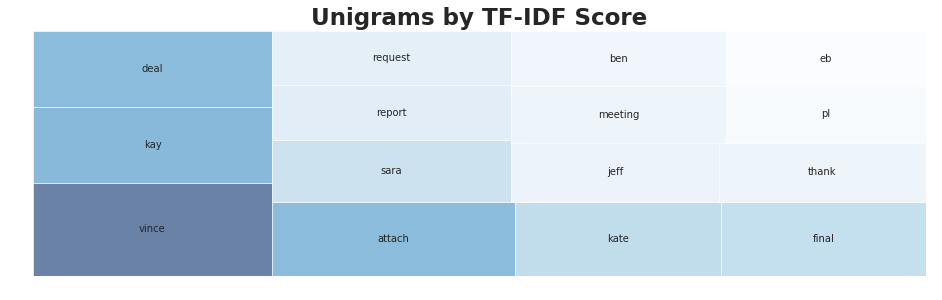

In [62]:
sq1 = df_1[['word', 'tfidf']].tail(15)
sq1 = sq1.sort_values(by='tfidf', axis=0, ascending=False)

#Utilise matplotlib to scale our goal numbers between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(sq1.tfidf), vmax=max(sq1.tfidf))
colors = [matplotlib.cm.Blues(norm(value)) for value in sq1.tfidf]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=sq1.word, sizes=sq1.tfidf, color = colors, alpha=.6)
plt.title("Unigrams by TF-IDF Score",fontsize=23,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()

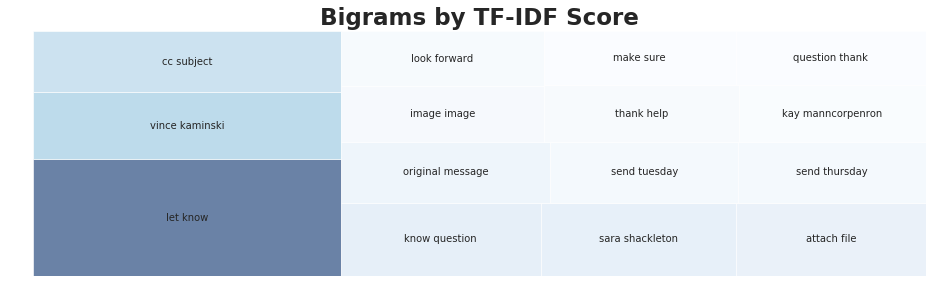

In [63]:
sq2 = df_2[['word', 'tfidf']].tail(15)
sq2 = sq2.sort_values(by='tfidf', axis=0, ascending=False)

#Utilise matplotlib to scale our goal numbers between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(sq2.tfidf), vmax=max(sq2.tfidf))
colors = [matplotlib.cm.Blues(norm(value)) for value in sq2.tfidf]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=sq2.word, sizes=sq2.tfidf, color = colors, alpha=.6)
plt.title("Bigrams by TF-IDF Score",fontsize=23,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()

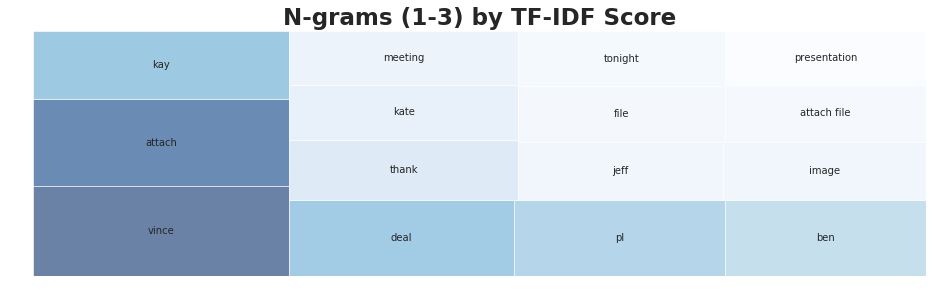

In [64]:
sq1_3 = df_1_3[['word', 'tfidf']].tail(15)
sq1_3 = sq1_3.sort_values(by='tfidf', axis=0, ascending=False)

#Utilise matplotlib to scale our goal numbers between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(sq1_3.tfidf), vmax=max(sq1_3.tfidf))
colors = [matplotlib.cm.Blues(norm(value)) for value in sq1_3.tfidf]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=sq1_3.word, sizes=sq1_3.tfidf, color = colors, alpha=.6)
plt.title("N-grams (1-3) by TF-IDF Score",fontsize=23,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()

## Topic models

In [65]:
# get a list of all the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(N)]
# turn that into a data frame with N rows and K columns, each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)

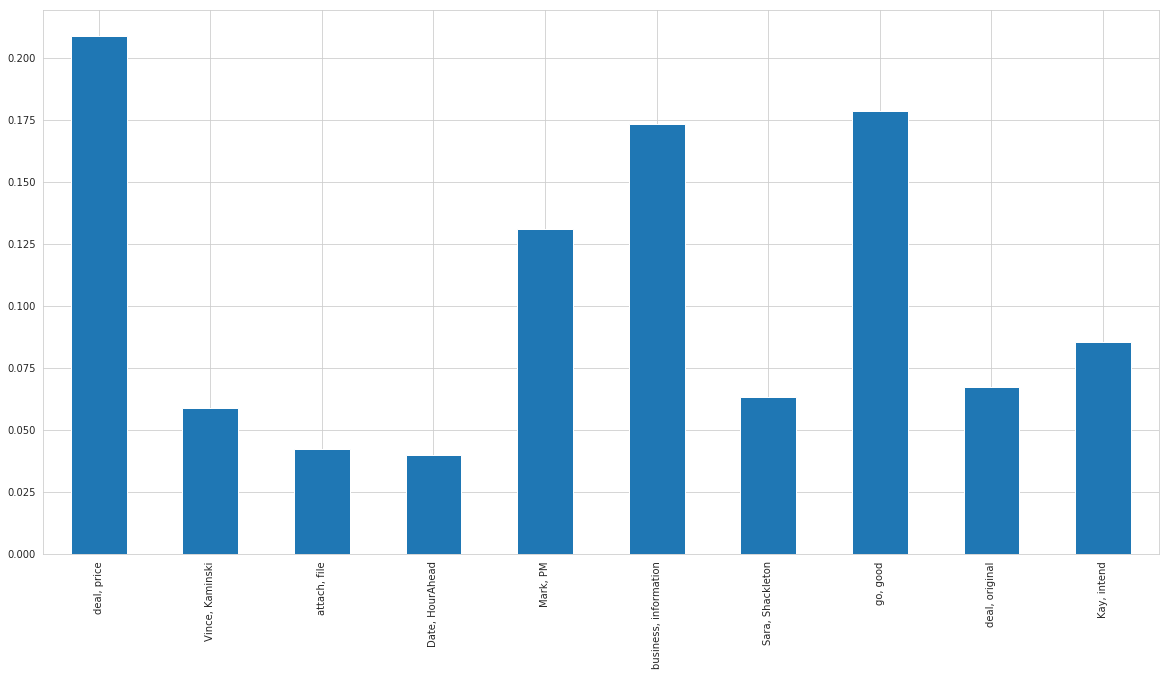

In [66]:
fig, ax = plt.subplots(figsize=(20, 10)) # set graph size
# aggregate topics by review categories
aggregate_by_category = topic_distros.mean()
# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);

## Latent Dimensions: Clustering

In [67]:
from matplotlib import colors

def plot_vectors(vectors, title='K-Means Clustering: k=10', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. If supplied, color them according to the labels
    """
    # set up graph
    fig = plt.figure(figsize=(20,20))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('afmhot') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)] # assigning color to each row
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], df2['z'], c=label_colors[l], cmap=cMap, edgecolor=None, label=label, alpha=0.3, s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            ax.scatter(df2['x'], df2['y'], c=label_colors[l], cmap=cMap, edgecolor=None, label=label, alpha=0.3, s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.show()

In [68]:
k = 10

# reduce the dimensionality of the input
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

kmeans = KMeans(n_clusters=k)

CPU times: user 12.9 s, sys: 376 ms, total: 13.3 s
Wall time: 4.12 s


In [69]:
X.shape

(10001, 17027)

In [70]:
sample = np.random.choice(len(X2), replace=False, size=N) # SIZE - be careful
%time kmeans_sample = kmeans.fit_predict(X2[sample])

CPU times: user 15.4 s, sys: 4 ms, total: 15.4 s
Wall time: 3.91 s


In [71]:
kmeans_sample

array([2, 0, 2, ..., 6, 2, 2], dtype=int32)

In [72]:
# let's get the centroid/average of each cluster
centroids = np.array([X2[sample][kmeans_sample == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(10, 300)


In [73]:
# initialize k-means with the agglomerative clusters
km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)

%time km.fit(X2)

/home/lini/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


CPU times: user 691 ms, sys: 228 ms, total: 919 ms
Wall time: 14.9 s


KMeans(algorithm='auto', copy_x=True,
    init=array([[ 1.84954e-01,  2.43925e-03, ..., -5.06032e-05,  1.46924e-04],
       [ 1.05611e-01, -6.24088e-03, ...,  2.47928e-03,  3.67487e-03],
       ...,
       [ 2.51667e-01, -2.16935e-02, ...,  2.52840e-04, -2.36269e-04],
       [ 1.67232e-01, -2.83759e-02, ..., -1.01187e-04, -2.56978e-04]]),
    max_iter=300, n_clusters=10, n_init=10, n_jobs=-1,
    precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

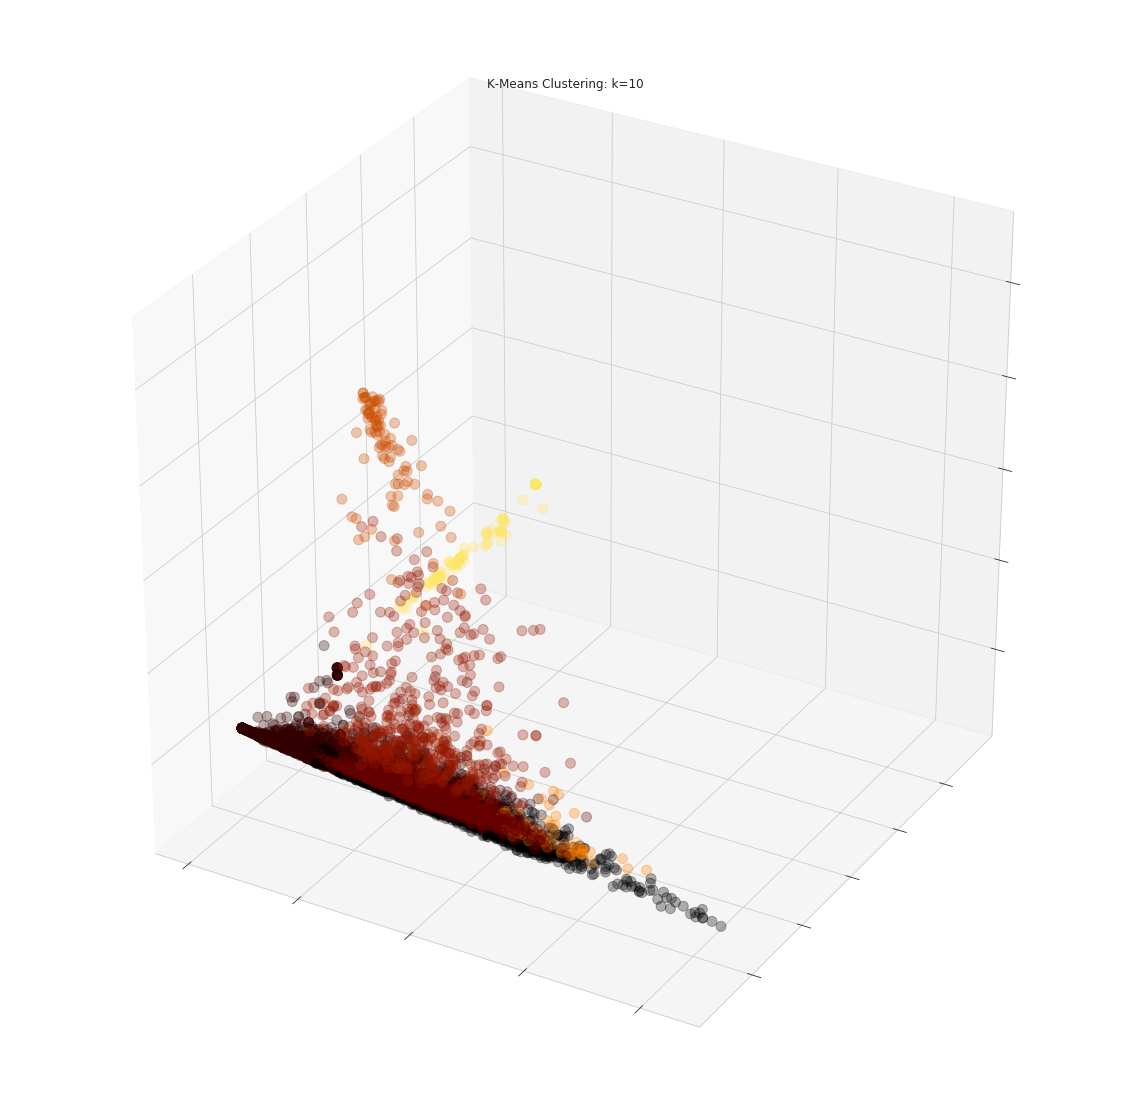

In [74]:
plot_sample = np.random.choice(len(X2), replace=False, size=N) # size, be careful
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

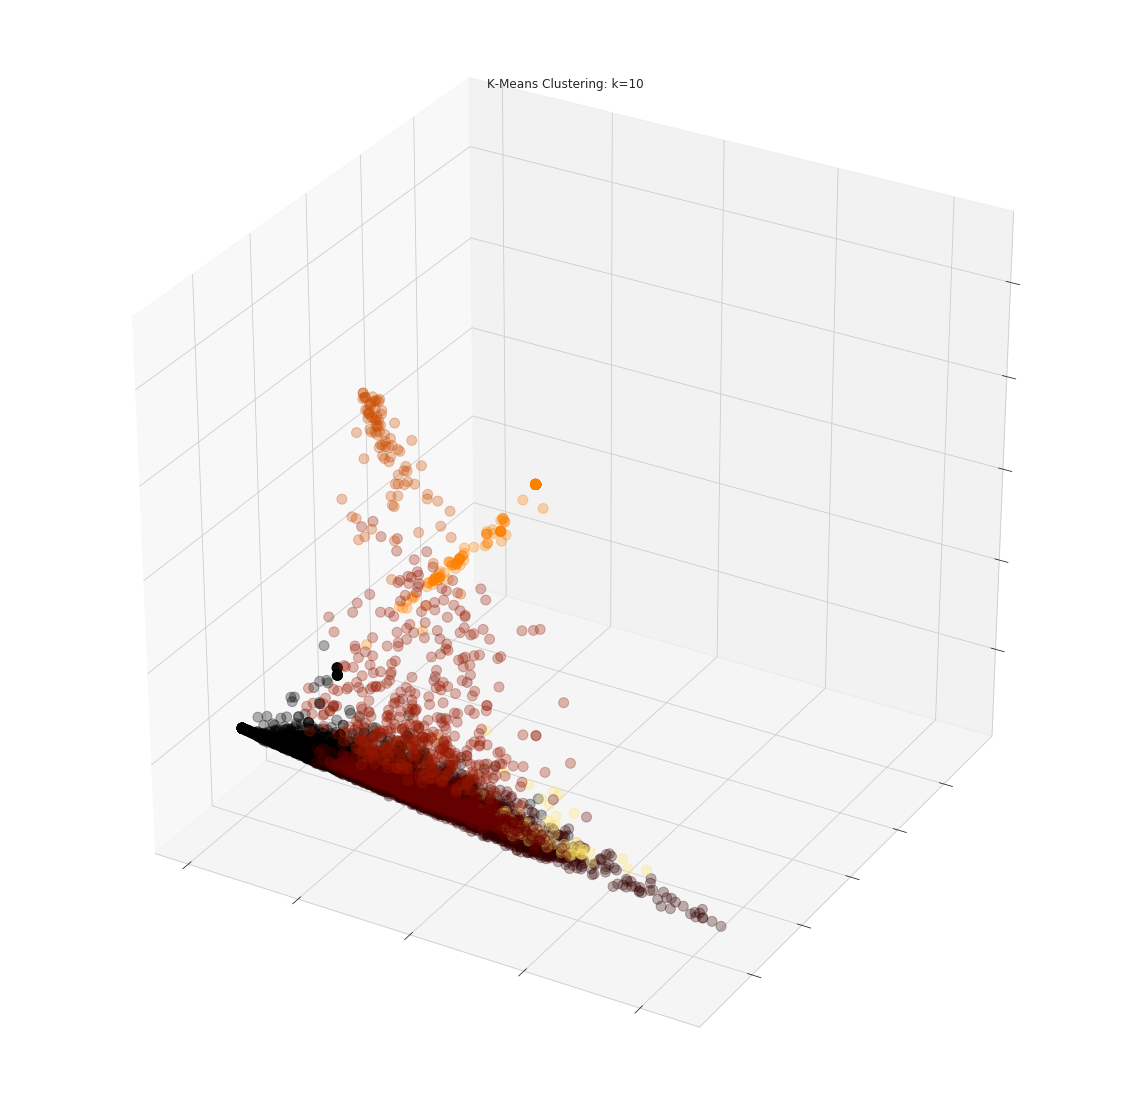

In [75]:
plot_vectors(X2[sample[:N]], labels=kmeans_sample[:N]) # size, be careful

The division of clusters is clearly visible.

## Other (possibly) interesting ideas

In [ ]:
os._exit(00)

# Restart the kernel here to free the memory up, and load the CSV file. Load the packages again.

In [1]:
# Loading of the needed packages

# System
import os

# Data analysis and processing
import pandas as pd
import numpy as np
import random
import email
import spacy
from nltk import SnowballStemmer # for Stemming
from sklearn.feature_extraction.text import CountVectorizer # For matrix representations and tfidf table
from sklearn.feature_extraction.text import TfidfVectorizer # For matrix factorization 
from collections import Counter # For counting tokens
from collections import defaultdict # For stemming and topic models
from nltk.tokenize.regexp import RegexpTokenizer
import re # Regex
import nltk # Natural language toolkit
import itertools
import string # For regex
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import time # To know how long training took
import multiprocessing # To speed things up by parallelizing
from sklearn.decomposition import TruncatedSVD # For SVD
from sklearn.decomposition import NMF # For NMF
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION


# Network analysis
import networkx as nx # Network analysis


# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import squarify

%matplotlib inline

os.system("taskset -p 0xff %d" % os.getpid())
print(os.getcwd())

/home/lini/Desktop/II semester/NATURAL LANGUAGE PROCESSING/midterm/3002493


In [2]:
# Random sampling
# Code wass initially writen and tested on smaller chunk of data, in order to speed up the process
N = 100001
df = pd.read_csv('emails.csv').sample(n=N, replace=False) 

In [3]:
df.head()

,file,message
486125,taylor-m/time_off/207.,Message-ID: <10793287.1075860329111.JavaMail.e...
480270,taylor-m/inbox/social/43.,Message-ID: <19372104.1075862103247.JavaMail.e...
387475,sager-e/notes_inbox/394.,Message-ID: <3649511.1075859540841.JavaMail.ev...
478768,taylor-m/archive/november1999/1.,Message-ID: <4787558.1075859979186.JavaMail.ev...
460534,sturm-f/deleted_items/4.,Message-ID: <8173316.1075841601912.JavaMail.ev...


In [4]:
df.shape

(100001, 2)

In [5]:
# Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain': # Extracting text data
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [6]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
# Parse content from emails
df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del messages

In [7]:
print('shape of the dataframe:', df.shape)
# Find number of unique values in each columns
for col in df.columns:
    print(col, df[col].nunique())

shape of the dataframe: (100001, 18)
file 100001
Message-ID 100001
Date 76745
From 10182
To 24933
Subject 62126
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 2
X-From 13156
X-To 31457
X-cc 13428
X-bcc 21
X-Folder 3856
X-Origin 258
X-FileName 421
content 82136
user 150


In [8]:
# Set index and drop columns with two few values
df = df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)

In [9]:
# Parse datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, utc=True) # It shows UTC time

In [10]:
df.dtypes

Date          datetime64[ns, UTC]
From                       object
To                         object
Subject                    object
X-From                     object
X-To                       object
X-cc                       object
X-bcc                      object
X-Folder                   object
X-Origin                   object
X-FileName                 object
content                    object
user                       object
dtype: object

In [11]:
print(df.shape)
for col in df.columns:
    print(col, df[col].nunique())

(100001, 13)
Date 76745
From 10182
To 24933
Subject 62126
X-From 13156
X-To 31457
X-cc 13428
X-bcc 21
X-Folder 3856
X-Origin 258
X-FileName 421
content 82136
user 150


In [12]:
df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
Message-ID,,,,,,,,,,,,,
<10793287.1075860329111.JavaMail.evans@thyme>,2001-05-15 09:32:00+00:00,(keegan.farrell@enron.com),"(tana.jones@enron.com, francisco.leite@enron.c...",Cheryl Nelson,Keegan Farrell,"Mark Taylor, Robert Bruce, Mary Cook, Angela D...",,,\Mark_Taylor_Jun2001\Notes Folders\Time off,Taylor-M,mtaylor.nsf,Good Morning!\n\nFYI - Cheryl will not be in t...,taylor-m
<19372104.1075862103247.JavaMail.evans@thyme>,2001-10-18 04:03:11+00:00,(lsutommy@hotmail.com),(e.taylor@enron.com),Re: RE: Bachelor party,Thomas Lahey <lsutommy@hotmail.com>,"Taylor, Michael E </O=ENRON/OU=NA/CN=RECIPIENT...",POSIEDON45@aol.com,,"\MTAYLOR5 (Non-Privileged)\Taylor, Michael E\I...",Taylor-M,MTAYLOR5 (Non-Privileged).pst,"Hey fellas,\n I'm not going to make it this we...",taylor-m
<3649511.1075859540841.JavaMail.evans@thyme>,2000-12-05 16:18:00+00:00,(janette.elbertson@enron.com),"(sandi.braband@enron.com, leslie.hansen@enron....",Super Saturday - Associate/Analyst Program,Janette Elbertson,"Alan Aronowitz, Peggy Banczak, Sandi M Braband...","Mark E Haedicke, Jacqueline Coleman, Suzanne A...",,\Elizabeth_Sager_Dec2000\Notes Folders\Notes i...,Sager-E,esager.nsf,Our recruiting folks need any available office...,sager-e
<4787558.1075859979186.JavaMail.evans@thyme>,1999-11-01 10:08:00+00:00,(rhett.jackson@enron.com),"(bob.shults@enron.com, dale.neuner@enron.com, ...","Risk Management & Trading Corp. (""RMT"") Guidel...",Rhett Jackson,"Sally Beck, Dale Neuner, Peter Keohane, Sara S...","Morris Richard Clark, Stephen H Douglas, James...",,\Mark_Taylor _Dec_2000\Notes Folders\Archive\N...,Taylor-M,mtaylor.nsf,Attached please find the most recent guideline...,taylor-m
<8173316.1075841601912.JavaMail.evans@thyme>,2002-02-06 17:18:35+00:00,(julie.clyatt@enron.com),"(martin.lin@enron.com, j..sturm@enron.com, ner...",YOU HAVE 48 HOURS - Message from Louise Kitchen,"Clyatt, Julie </O=ENRON/OU=NA/CN=RECIPIENTS/CN...","Abler, Bill </O=ENRON/OU=NA/CN=RECIPIENTS/CN=W...",,,"\ExMerge - Sturm, Fletcher J.\Deleted Items",STURM-F,fletcher sturm 6-26-02.PST,\n\nIt appears that the following email may no...,sturm-f


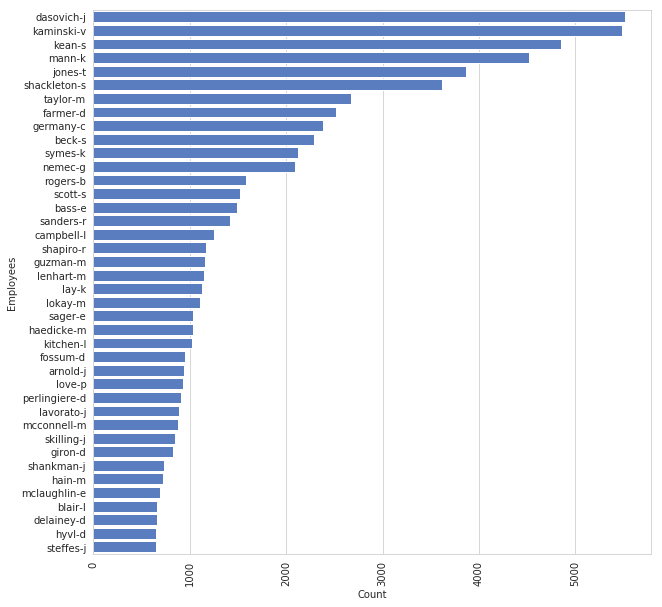

In [13]:
# Visualize e-mail count by employee

def barplot(df, X, Y, figsize, color, orient, ylabel, xlabel, font_scale, rotation):
    f, ax = plt.subplots(figsize=figsize)
    sns.set_color_codes("muted")
    sns.barplot(x = X, y = Y, data = df, color = color, orient = orient)
    ax.set(ylabel = ylabel, xlabel = xlabel)
    sns.set(font_scale = font_scale)
    plt.xticks(rotation = rotation) 
    plt.show()


mail_count = df["user"].value_counts()
indices = mail_count.index
count = pd.DataFrame(mail_count)
count.rename(columns = {"user": "Count"}, inplace = True)
count["user"] = indices
barplot(df = count[:40], X = "Count", Y = "user", figsize = (10, 10), color = 'b', orient = 'h',\
        ylabel = "Employees", xlabel = "Count", font_scale = .8, rotation = 90)

Here we can notice that there is a small number of employees who facilitate email communication, while the others tend to send much less emails.

In [14]:
# Social network analysis of email senders and recipients
sub_df = df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(95781, 3)
(68448, 3)


In [15]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
13253,pete.davis@enron.com,pete.davis@enron.com,1728
15606,vince.kaminski@enron.com,vkaminski@aol.com,847
15250,enron.announcements@enron.com,all.worldwide@enron.com,441
15247,enron.announcements@enron.com,all.houston@enron.com,327
14619,kay.mann@enron.com,suzanne.adams@enron.com,293
15600,vince.kaminski@enron.com,shirley.crenshaw@enron.com,230
14983,steven.kean@enron.com,maureen.mcvicker@enron.com,204
14377,kate.symes@enron.com,kerri.thompson@enron.com,181
14620,kay.mann@enron.com,nmann@erac.com,176
14371,kate.symes@enron.com,evelyn.metoyer@enron.com,167


In [16]:
# Make a network of email sender and receipients
G = nx.from_pandas_edgelist(sub_df, 'From', 'To', edge_attr='count', create_using=nx.Graph())
print('Number of nodes: %d, Number of edges: %d' % (G.number_of_nodes(), G.number_of_edges()))

Number of nodes: 13191, Number of edges: 22188


/home/lini/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


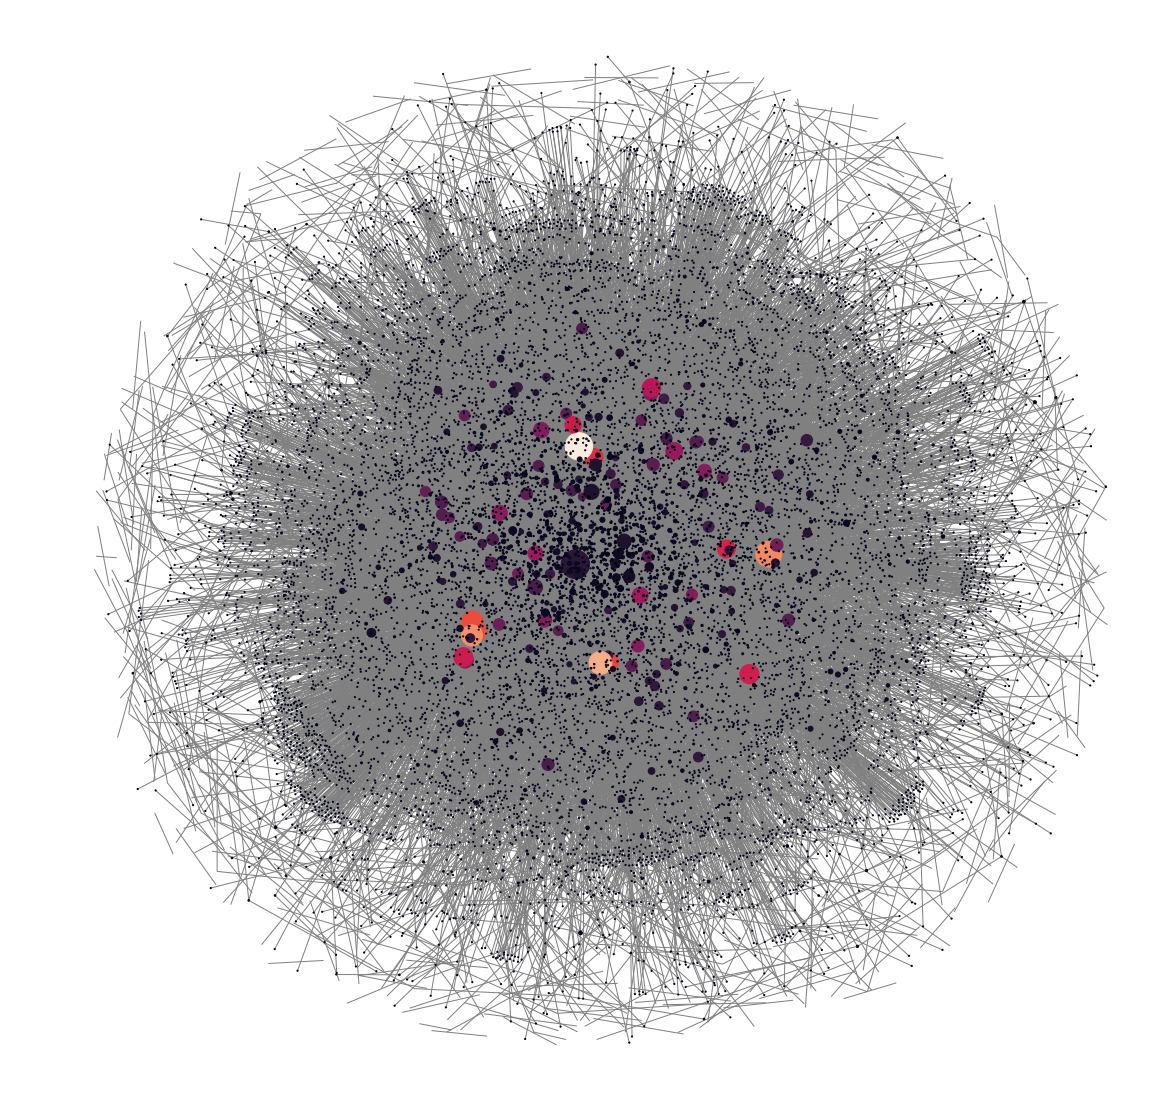

In [17]:
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=.07)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]


nx.draw_networkx(G, pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size,
                 edge_color='grey');
plt.axis('off');

I have used N = 100,001, which is about 19.3% percent of total email number. This gives us 13191 nodes to connect.

From the graph we can see formed 'hubs' - people tend to communicate within departments and have some kind of 'central' persona who is connecting them.